In [143]:
# SPA vs COIN_FF vs COIN_FF_RL (imitation of COIN_FF)

import math
import random
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Set, Counter
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
import networkx as nx
import heapq
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Load shapefile and build TrafficNetwork

In [2]:
# Path to your shapefile
path = "../trimmed_manhattan_shape/trimmed_manhattan.shp"
gdf = gpd.read_file(path)
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

# If CRS is geographic (lat/lon), reproject to EPSG:2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
print("Reprojected CRS: ", gdf.crs)

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']
Reprojected CRS:  EPSG:2263


## Constants of the network

In [164]:

# =========================
# Types
# =========================
Node = Tuple[float, float]          # (x, y)
EdgeId = Tuple[Node, Node]          # directed edge
EdgeFlows = Dict[EdgeId, float]     # typically veh/hour if used in BPR
Graph = Dict[Node, List[EdgeId]]


def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    """Rounding keeps nodes consistent instead of tiny float differences."""
    return round(x, ndigits), round(y, ndigits)


# =========================
# Constants (consistent units)
# =========================
FT_TO_M = 0.3048006096          # EPSG:2263 is US survey feet
SPACE_PER_VEH_M = 7.5           # avg standstill spacing: car length + gap (meters/veh)
MIN_STORAGE_CAP = 1             # minimum storage vehicles per directed edge

# BPR parameters
BPR_ALPHA = 0.15
BPR_BETA = 4.0

# Flow (throughput) capacity per lane for Manhattan-like signalized streets (tunable)
Q_SAT_VPHPL = 900.0             # veh/hour/lane


# Optional: rough defaults by highway type if lanes missing (keep if useful)
HIGHWAY_DEFAULT_LANES = {
    "motorway": 6,
    "trunk": 5,
    "primary": 5,
    "secondary": 4,
    "tertiary": 2,
    "residential": 2,
    "service": 1,
}


def parse_lanes(row: dict, default: int = 1) -> int:
    """
    Robust lane parsing:
    - uses row['lanes'] if present
    - else falls back to row['highway'] defaults
    """
    val = row.get("lanes", None)
    if val is None or (isinstance(val, float) and math.isnan(val)):
        hw = row.get("highway", None)
        return max(1, int(HIGHWAY_DEFAULT_LANES.get(hw, default)))

    try:
        if isinstance(val, str):
            # handle "2;3", "2|3", "2,3" etc. -> take first token
            for sep in (";", "|", ","):
                if sep in val:
                    val = val.split(sep)[0]
                    break
            val = val.strip()
        lanes = int(float(val))
        return max(1, lanes)
    except Exception:
        hw = row.get("highway", None)
        return max(1, int(HIGHWAY_DEFAULT_LANES.get(hw, default)))


def sample_free_speed_time_based() -> float:
    """
    Sample free-flow speed via a lognormal model on time-per-meter.
    Returns m/s, clamped to ~18–90 km/h (5–25 m/s).
    """
    median_s_per_m = 0.09  # ~11.11 m/s (~40 km/h)
    mu = math.log(median_s_per_m)
    sigma = 0.3
    s_per_m = random.lognormvariate(mu, sigma)  # seconds per meter
    v_free = 1.0 / s_per_m

    return max(min(v_free, 25.0), 5.0)



## Data Classes of the network

In [495]:
@dataclass
class Edge:
    start: Node
    end: Node
    length_m: float            # meters
    v_free: float              # m/s

    storage_cap: int           # vehicles (max vehicles that fit on segment)
    flow_cap_vph: float        # vehicles/hour (throughput capacity for BPR)

    alpha: float = BPR_ALPHA
    beta: float = BPR_BETA

    @property
    def free_time(self) -> float:
        """Free-flow travel time (seconds)."""
        return self.length_m / self.v_free if self.v_free > 0 else float("inf")

    def travel_time(self, flow_vph: float) -> float:
        """
        BPR travel time.
        IMPORTANT: flow_vph must be in vehicles/hour, and is compared to flow_cap_vph (vehicles/hour).
        """
        if self.flow_cap_vph <= 0:
            return float("inf")
        x = max(0.0, flow_vph / self.flow_cap_vph)
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]

## Network builder

In [496]:
# =========================
# Network builder
# =========================
def network_from_streets_gdf(streets_gdf: gpd.GeoDataFrame) -> Tuple[TrafficNetwork, List[int]]:
    """
    Build a directed TrafficNetwork from a GeoDataFrame of street segments.

    Assumptions:
    - Input geometries are in EPSG:2263 (US survey feet).
    - We convert lengths to meters internally.
    - storage_cap = physical storage capacity (veh).
    - flow_cap_vph = throughput capacity (veh/h) for BPR.
    """
    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    storage_caps: List[int] = []

    for _, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue

        lanes = parse_lanes(row, default=1)

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            # endpoints become graph nodes
            u = make_node(*coords[0])
            v = make_node(*coords[-1])

            # length: feet -> meters
            length_m = float(line.length) * FT_TO_M

            # fixed storage capacity (veh)
            storage_cap = max(
                MIN_STORAGE_CAP,
                int((length_m * lanes) // SPACE_PER_VEH_M)
            )
            storage_caps.append(storage_cap)

            # speed affects travel time and (optionally) an upper bound on flow cap
            v_free = sample_free_speed_time_based()  # m/s

            # flow cap for BPR (veh/h): cap by signalized saturation and speed-based upper bound
            q_speed_vphpl = (v_free / SPACE_PER_VEH_M) * 3600.0
            q_lane_vph = min(q_speed_vphpl, Q_SAT_VPHPL)
            flow_cap_vph = lanes * q_lane_vph

            def _add_edge(a: Node, b: Node):
                eid = (a, b)
                if eid in edges:
                    # keep the "stronger" version if duplicates occur
                    if length_m > edges[eid].length_m:
                        edges[eid].length_m = length_m
                        edges[eid].storage_cap = storage_cap
                        edges[eid].flow_cap_vph = flow_cap_vph
                        edges[eid].v_free = v_free
                    return

                edges[eid] = Edge(
                    start=a,
                    end=b,
                    length_m=length_m,
                    v_free=v_free,
                    storage_cap=storage_cap,
                    flow_cap_vph=flow_cap_vph,
                )
                graph[a].append(eid)

            # add both directions
            _add_edge(u, v)
            _add_edge(v, u)

    return TrafficNetwork(graph=dict(graph), edges=edges), storage_caps



## Create the manhattan network

In [303]:
# Build network
manhattan_network, capacities = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")

# nodes: 6701
# edges: 16444


In [304]:
def count_dead_ends(network: TrafficNetwork) -> int:
    outdeg = {n: len(network.graph.get(n, [])) for n in network.graph.keys()}
    indeg = defaultdict(int)
    for (u, v) in network.edges.keys():
        indeg[v] += 1
    dead = [n for n in set(outdeg) | set(indeg) if (outdeg.get(n,0) + indeg.get(n,0)) <= 1]
    return len(dead)

print("Dead-end-ish nodes:", count_dead_ends(manhattan_network))

Dead-end-ish nodes: 0


1 2225


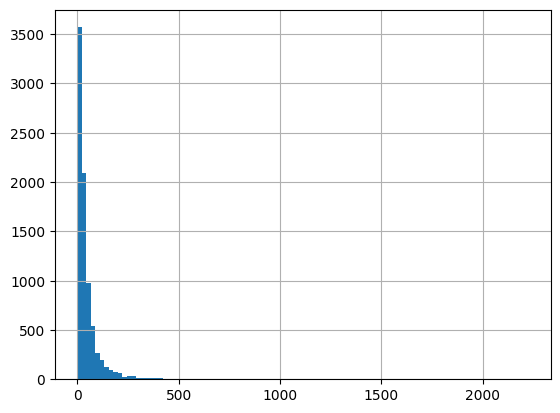

In [168]:
capacities = pd.Series(capacities)
capacities.hist(bins=100)
print(min(capacities), max(capacities))

## NetworkX conversion (for sanity plot)

In [301]:
def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()

    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])

    for edge in network.edges.values():
        G.add_edge(
            edge.start,
            edge.end,
            free_time=edge.free_time,          # seconds
            storage_cap=edge.storage_cap,      # vehicles (queue size)
            flow_cap_vph=edge.flow_cap_vph,    # vehicles/hour (throughput)
            length_m=edge.length_m,
            v_free=edge.v_free,
        )

    return G


G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

# NX nodes: 6701 # NX edges: 16444


### Print Network X graph

In [ ]:
pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

## Agents + OD selection

In [7]:
@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None


def sample_agents_random(network: TrafficNetwork, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def sample_agents_north_south(
    network: TrafficNetwork,
    num_agents: int,
    band_split: float = 0.5,
) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]
    assert north_nodes and south_nodes, "North/south bands empty – check CRS/band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def pick_north_south_pair(network: TrafficNetwork) -> Tuple[Node, Node]:
    """Pick a single north–south OD pair to keep SPA / COIN_FF comparable."""
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)

    # north = top 20%, south = bottom 20%
    north_nodes = [n for n in nodes if n[1] >= y_min + 0.8 * (y_max - y_min)]
    south_nodes = [n for n in nodes if n[1] <= y_min + 0.2 * (y_max - y_min)]

    o = random.choice(north_nodes)
    d = random.choice(south_nodes)
    return o, d


def sample_agents_fixed(
    network: TrafficNetwork,
    num_agents: int,
    origin: Node,
    destination: Node
) -> List[Agent]:
    return [Agent(origin=origin, destination=destination) for _ in range(num_agents)]


# Routing Algorithms

## Dijkstra (SPA)

In [ ]:
def dijkstra(network: TrafficNetwork, source: Node, target: Node, edge_flow_vph: EdgeFlows) -> List[Node]:
    """Dijkstra where cost = travel time t(flow_vph)."""
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flow_vph.get(edge_id, 0.0))
            nd = d_u + w
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []

    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path



In [ ]:
def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))

def spa_route_all(
    network: TrafficNetwork,
    agents: List[Agent],
    horizon_s: float = 3600.0,   # interpret all agents as demand over this time horizon
) -> Tuple[List[Agent], EdgeFlows]:
    """
    Selfish Path Assignment (SPA):
    edge_counts[e] is a vehicle count; we convert to flow_vph for BPR.
    """
    edge_counts: EdgeFlows = defaultdict(float)

    for agent in agents:
        # convert current counts -> flow (veh/h)
        edge_flow_vph = {e: c * (3600.0 / horizon_s) for e, c in edge_counts.items()}

        path = dijkstra(network, agent.origin, agent.destination, edge_flow_vph)
        agent.path = path

        for e in edges_from_path(path):
            edge_counts[e] += 1.0

    return agents, edge_counts

## FF

In [225]:

DELTA_VPH = 50.0

def edge_marginal_cost(edge: Edge, flow_before_vph: float, delta_vph: float = DELTA_VPH) -> float:
    """Marginal increase in total system travel time proxy when flow increases by delta_vph."""
    f1 = flow_before_vph
    f2 = flow_before_vph + delta_vph
    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)
    return (f2 * t2) - (f1 * t1)

# If True, keep old behavior: block edges when storage is full.
# Recommended: False (soft penalty) so FF produces many routes and reaches destination.
HARD_STORAGE_BLOCK = False

# Soft penalty for (occupancy / storage_cap)^P added to marginal edge cost.
KAPPA_STORAGE = 200.0   # try 50, 200, 500 (bigger => stronger avoidance)
P_STORAGE     = 6.0     # try 4–8 (bigger => harsher near-capacity)

# Optional tiny noise so the expert doesn't collapse into identical ties everywhere
FF_NOISE_EPS = 0.02     # 0.00–0.05

def storage_penalty(edge: Edge, occ_before: float) -> float:
    """
    Smoothly discourages edges that are close to / above storage capacity.
    occ_before is a vehicle COUNT on that directed edge.
    """
    cap = max(edge.storage_cap, 1.0)
    rho = occ_before / cap
    return KAPPA_STORAGE * (rho ** P_STORAGE)


def edge_marginal_cost_soft(
    edge: Edge,
    flow_before_vph: float,
    occ_before: float,
    delta_vph: float = DELTA_VPH,
) -> float:
    """
    Marginal cost for FF routing:
      (system marginal cost based on BPR using flow_vph)
      + soft storage penalty based on occupancy/storage_cap
      + tiny noise (optional)
    """
    # system marginal cost proxy
    base = edge_marginal_cost(edge, flow_before_vph, delta_vph=delta_vph)

    # soft storage discouragement (prevents expert from using only 1–4 routes then failing)
    pen = storage_penalty(edge, occ_before)

    # tiny noise to break ties
    if FF_NOISE_EPS > 0:
        base *= (1.0 + FF_NOISE_EPS * (random.random() - 0.5))

    return base + pen

def dijkstra_coin_ff_marginal(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flow_vph: EdgeFlows,
    edge_occ: Dict[EdgeId, int],
) -> List[Node]:
    """
    Shortest path where edge weight is:
      marginal system travel-time cost (BPR, using flow_vph)
      + SOFT penalty for near-full storage (using occupancy vs storage_cap)

    If HARD_STORAGE_BLOCK=True, we revert to hard blocking.
    """
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        cost_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end

            occ_before = float(edge_occ.get(edge_id, 0))

            # OPTIONAL: keep old behavior if you want a hard storage cap
            if HARD_STORAGE_BLOCK and occ_before >= edge.storage_cap:
                continue

            f_before_vph = float(edge_flow_vph.get(edge_id, 0.0))

            # NEW: soft marginal cost
            marginal = edge_marginal_cost_soft(
                edge,
                flow_before_vph=f_before_vph,
                occ_before=occ_before,
            )

            new_cost = cost_u + marginal

            if v not in dist or new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return []

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path





In [229]:
def ford_fulkerson_route_all(
    network: TrafficNetwork,
    agents: List[Agent],
    horizon_s: float = 3600.0,
) -> Tuple[List[Agent], EdgeFlows]:
    """
    COIN-ish routing with marginal cost:
    - edge_counts = occupancy proxy (veh)
    - edge_flow_vph = derived (veh/h) for travel_time/marginal costs
    - block edges when edge_counts >= edge.storage_cap
    """
    edge_counts: EdgeFlows = defaultdict(float)

    for agent in agents:
        edge_flow_vph = {e: c * (3600.0 / horizon_s) for e, c in edge_counts.items()}
        edge_occ = {e: int(c) for e, c in edge_counts.items()}  # occupancy as int vehicles

        path = dijkstra_coin_ff_marginal(
            network,
            agent.origin,
            agent.destination,
            edge_flow_vph=edge_flow_vph,
            edge_occ=edge_occ,
        )
        agent.path = path

        for e in edges_from_path(path):
            edge_counts[e] += 1.0

    return agents, edge_counts


# World utility & OD used for fixed experiments

In [230]:
def total_system_travel_time(
    network: TrafficNetwork,
    edge_counts: EdgeFlows,
    horizon_s: float = 3600.0,
) -> float:
    """Total system travel time in seconds."""
    total_s = 0.0
    scale = 3600.0 / horizon_s  # counts -> veh/hour

    for e_id, count in edge_counts.items():
        edge = network.edges[e_id]
        flow_vph = count * scale
        total_s += count * edge.travel_time(flow_vph)

    return total_s


# Fixed OD pair (global, to keep things simple and consistent)
origin, destination = pick_north_south_pair(manhattan_network)
zero_flows = defaultdict(float)
shortest_path = dijkstra(manhattan_network, origin, destination, zero_flows)
shortest_edges = set(edges_from_path(shortest_path))

print("Origin:", origin)
print("Destination:", destination)
print("Shortest path length (edges):", len(shortest_path))


def dist_to_dest(node: Node, dest: Node) -> float:
    return math.dist(node, dest)

Origin: (1002368.338, 253337.757)
Destination: (984030.915, 199876.931)
Shortest path length (edges): 128


# Coin

## Difference reward helpers

In [497]:
# --- COIN / difference–reward helpers ---------------------------------

def edge_global_cost(
    edge: Edge,
    count: float,
    horizon_s: float,
) -> float:
    """
    Global contribution of a single edge to total system travel time:

        G_e = count * T_e(flow_vph)

    where:
        flow_vph = count * (3600 / horizon_s)

    Units: seconds
    """
    flow_vph = count * (3600.0 / horizon_s)
    return count * edge.travel_time(flow_vph)


def edge_marginal_global_cost(
    edge: Edge,
    count_before: float,
    horizon_s: float,
) -> float:
    """
    Marginal increase in total system travel time caused by
    adding ONE additional vehicle to this edge.

    Units: seconds
    """
    return (
        edge_global_cost(edge, count_before + 1.0, horizon_s)
        - edge_global_cost(edge, count_before, horizon_s)
    )

## Online Q

### Expert dataset

In [232]:
def build_ff_expert_dataset(
    network: TrafficNetwork,
    num_agents: int = 200,
    od_mode: str = "fixed",
    horizon_s: float = 3600.0,
):
    """
    Run Ford–Fulkerson-based assignment once and record expert transitions.

    Returns
    -------
    expert_steps : list of (s, d, a, edge_id)
    agents_ff : list[Agent]
    flows_ff  : EdgeFlows   (THIS IS EDGE COUNTS, vehicles per edge)
    """
    # --- sample agents according to od_mode ----
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    # --- route using Ford–Fulkerson expert (Option A: count-based + horizon) ---
    agents_ff, edge_counts_ff = ford_fulkerson_route_all(network, agents, horizon_s=horizon_s)

    expert_steps = []
    for agent in agents_ff:
        if not agent.path or agent.path[-1] != agent.destination:
            continue
        d = agent.destination
        for (s, a) in edges_from_path(agent.path):
            edge_id = (s, a)
            expert_steps.append((s, d, a, edge_id))

    print(
        f"Collected {len(expert_steps)} FF-expert (s,d,a,edge_id) steps "
        f"from {len(agents_ff)} agents."
    )

    return expert_steps, agents_ff, edge_counts_ff

### Helpers

In [233]:
def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]


def edge_congestion_bin(edge: Edge, flow_vph: float) -> int:
    """
    Discretize congestion into 3 bins for COIN-style state.
    Uses FLOW capacity (veh/h), consistent with BPR.

      0 = low    (v/c < 0.3)
      1 = medium (0.3 <= v/c < 0.7)
      2 = high   (v/c >= 0.7)
    """
    cap_vph = max(edge.flow_cap_vph, 1e-6)
    ratio = flow_vph / cap_vph

    if ratio < 0.3:
        return 0
    elif ratio < 0.7:
        return 1
    else:
        return 2

def dist_to_dest(node: Node, dest: Node) -> float:
    """Euclidean distance (in coordinate units) from node to dest."""
    x1, y1 = node
    x2, y2 = dest
    return math.hypot(x2 - x1, y2 - y1)

In [320]:
from dataclasses import dataclass, field
from collections import defaultdict
from typing import Any, Dict

@dataclass
class RewardDebug:
    enabled: bool = True
    n: int = 0
    sums: Dict[str, float] = field(default_factory=lambda: defaultdict(float))
    mins: Dict[str, float] = field(default_factory=lambda: defaultdict(lambda: float("inf")))
    maxs: Dict[str, float] = field(default_factory=lambda: defaultdict(lambda: float("-inf")))

    def add(self, **vals: Any) -> None:
        if not self.enabled:
            return
        self.n += 1
        for k, v in vals.items():
            if v is None:
                continue
            fv = float(v)
            self.sums[k] += fv
            self.mins[k] = min(self.mins[k], fv)
            self.maxs[k] = max(self.maxs[k], fv)

    def summary(self, name: str = "Reward breakdown") -> None:
        if not self.enabled or self.n == 0:
            print(f"[{name}] (no samples)")
            return

        print(f"\n[{name}] n={self.n}")
        for k in sorted(self.sums.keys()):
            mean = self.sums[k] / self.n
            print(
                f"  {k:8s}  mean={mean: .4f}   min={self.mins[k]: .4f}   max={self.maxs[k]: .4f}"
            )

In [576]:
def build_reverse_adj_weighted(network: TrafficNetwork) -> Dict[Node, List[Tuple[Node, float]]]:
    """Reverse adjacency with weights: for each v, list (u, w(u->v)). w = free-flow time."""
    rev = defaultdict(list)
    for (u, v), edge in network.edges.items():
        rev[v].append((u, float(edge.free_time)))
    return dict(rev)

def shortest_path_to_dest_freeflow(
    dest: Node,
    rev_adj_w: Dict[Node, List[Tuple[Node, float]]],
) -> Dict[Node, float]:
    """Dijkstra on reverse graph: gives min free-flow time from node -> dest."""
    dist = {dest: 0.0}
    pq = [(0.0, dest)]
    while pq:
        dv, v = heapq.heappop(pq)
        if dv != dist.get(v, float("inf")):
            continue
        for u, w in rev_adj_w.get(v, []):
            nd = dv + w
            if nd < dist.get(u, float("inf")):
                dist[u] = nd
                heapq.heappush(pq, (nd, u))
    return dist

In [456]:
# ============================================================
# Global RL / COIN constants
# ============================================================

# ===== RL / reward-shaping constants =====
TIME_SCALE   = 1000.0

# Difference–reward weight (already used)
LAMBDA_DR    = 0.3

# Optional shaping
LAMBDA_PROG  = 0.1      # progress towards destination
LAMBDA_TERM  = 10.0     # bonus if you reach destination
LAMBDA_EXP   = 0.1      # expert edge bonus

# NEW: extra shaping for path length
LAMBDA_STEP  = 0.01     # per-step cost (discourages very long routes)
LAMBDA_MISS  = 50.0     # penalty if you hit max_steps without reaching dest

### Q learning from expert (COIN)

In [598]:
def q_learning_train_true_coin_from_ff_expert(
    network: TrafficNetwork,
    expert_steps,
    flows_expert: EdgeFlows,
    expert_edge_ids: Set[EdgeId],
    num_episodes: int = 20,
    num_agents_per_episode: int = 100,
    od_mode: str = "fixed",
    alpha: float = 0.3,
    gamma: float = 0.95,
    epsilon_start: float = 0.3,
    epsilon_end: float = 0.05,
    max_steps_per_agent: int = 1500,
    # TRUE COIN + shaping weights
    lambda_dr: float   = LAMBDA_DR,
    lambda_prog: float = LAMBDA_PROG,
    lambda_term: float = LAMBDA_TERM,
    lambda_exp: float  = LAMBDA_EXP,
    lambda_step: float = LAMBDA_STEP,   # NOTE: set to 0.0 if using time penalty
    lambda_miss: float = LAMBDA_MISS,
    time_scale: float  = TIME_SCALE,
    horizon_s: float   = 3600.0,
    # debug
    debug_rewards: bool = True,
    # training-time anti-loop (keep small or 0.0)
    visited_penalty_train: float = 0.0,
    # training-time time penalty
    lambda_time_train: float = 1.0,     # set 0.0 to disable
    time_scale_s: float = 1000.0,       # seconds -> unitless scale
    t_cap_s: float = 3000.0,            # cap huge BPR times
    # soft detour allowance for action filtering
    tau: float = 0.05,                  # try 0.0–0.10
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    TRUE COIN Q-learning with difference rewards + expert shaping.

    Adds:
      - Reachability-only actions (avoid getting stuck in components)
      - Soft monotone-to-destination filter using SHORTEST-PATH-TO-DEST (free-flow time)
      - Optional training-time visited penalty
      - Training-time time penalty proportional to BPR travel time
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}

    def sample_agents_for_mode(n_agents: int) -> List[Agent]:
        if od_mode == "random":
            return sample_agents_random(network, n_agents)
        elif od_mode in ("north_south", "north-south"):
            return sample_agents_north_south(network, n_agents)
        else:
            return sample_agents_fixed(network, n_agents, origin, destination)

    # ============================================================
    # Build reachability (reverse adj) + shortest-path-to-dest cache
    # ============================================================
    from collections import defaultdict, deque
    import heapq

    # Reverse adjacency for reachability (unweighted)
    rev_adj = defaultdict(list)
    # Reverse adjacency for shortest-path-to-dest (weighted by free-flow time)
    rev_adj_w = defaultdict(list)

    for (u, v), edge in network.edges.items():
        rev_adj[v].append(u)
        rev_adj_w[v].append((u, float(edge.free_time)))

    reachable_cache: Dict[Node, Set[Node]] = {}
    sp_cache: Dict[Node, Dict[Node, float]] = {}

    def reachable_set(dest: Node) -> Set[Node]:
        rs = reachable_cache.get(dest)
        if rs is not None:
            return rs
        seen: Set[Node] = set([dest])
        q = deque([dest])
        while q:
            v = q.popleft()
            for u in rev_adj.get(v, []):
                if u not in seen:
                    seen.add(u)
                    q.append(u)
        reachable_cache[dest] = seen
        return seen

    def sp_dist_map(dest: Node) -> Dict[Node, float]:
        m = sp_cache.get(dest)
        if m is not None:
            return m
        dist: Dict[Node, float] = {dest: 0.0}
        pq = [(0.0, dest)]
        while pq:
            dv, v = heapq.heappop(pq)
            if dv != dist.get(v, float("inf")):
                continue
            for u, w in rev_adj_w.get(v, []):
                nd = dv + w
                if nd < dist.get(u, float("inf")):
                    dist[u] = nd
                    heapq.heappush(pq, (nd, u))
        sp_cache[dest] = dist
        return dist

    def progress_sp(sp: Dict[Node, float], s: Node, d: Node, a: Node) -> float:
        old_dist = sp.get(s, float("inf"))
        new_dist = sp.get(a, float("inf"))
        if not np.isfinite(old_dist) or old_dist <= 0.0:
            return 0.0
        prog = (old_dist - new_dist) / max(old_dist, 1.0)
        return max(0.0, prog)  # positive-only progress

    def filter_neighbors_reach_tau(sp: Dict[Node, float], s: Node, d: Node, neighbors: List[Node]) -> List[Node]:
        # allow small detours up to -tau in normalized progress
        old_dist = sp.get(s, float("inf"))
        if not np.isfinite(old_dist) or old_dist <= 0.0:
            return neighbors
        filtered = []
        for nxt in neighbors:
            new_dist = sp.get(nxt, float("inf"))
            prog_tmp = (old_dist - new_dist) / max(old_dist, 1.0)
            if prog_tmp >= -tau:
                filtered.append(nxt)
        return filtered if filtered else neighbors

    # counts -> veh/hour scale
    scale_to_vph = 3600.0 / float(horizon_s)

    # ============================================================
    # Step 0: offline initialization from FF expert transitions
    # ============================================================
    print("Initializing TRUE-COIN Q from Ford–Fulkerson expert trajectories...")

    for (s, d, a, edge_id) in expert_steps:
        edge = network.edges[edge_id]
        c_expert = flows_expert[edge_id]          # COUNT
        c_before = max(c_expert - 1.0, 0.0)       # COUNT

        delta_G = edge_marginal_global_cost(edge, c_before, horizon_s)
        delta_G = max(min(delta_G, 1e6), -1e6)
        dr = -lambda_dr * (delta_G / time_scale)

        sp = sp_dist_map(d)
        progress = progress_sp(sp, s, d, a)

        is_expert = 1.0 if edge_id in expert_edge_ids else 0.0

        reward = (
            dr
            + lambda_prog * progress
            + lambda_exp * is_expert
            - lambda_step
        )
        if a == d:
            reward += lambda_term

        key = (s, d, a)
        old_q = Q.get(key, 0.0)
        Q[key] = old_q + alpha * (reward - old_q)

    print(
        f"TRUE-COIN Q initialized on {len(expert_steps)} FF expert steps "
        f"(unique state–action pairs: {len(Q)})."
    )

    # ============================================================
    # Step 1: online TRUE COIN Q-learning
    # ============================================================
    for ep in range(num_episodes):
        epsilon = (epsilon_start + (epsilon_end - epsilon_start) * ep / (num_episodes - 1)) if num_episodes > 1 else epsilon_end

        edge_counts: EdgeFlows = defaultdict(float)  # COUNTS
        agents = sample_agents_for_mode(num_agents_per_episode)

        total_returns = 0.0
        total_steps = 0

        dbg = RewardDebug(enabled=debug_rewards)
        deltaG_samples = []

        for agent in agents:
            s = agent.origin
            d = agent.destination
            visited: Set[Node] = set()
            steps = 0
            G_ep = 0.0

            rs = reachable_set(d)
            sp = sp_dist_map(d)

            while s != d and steps < max_steps_per_agent:
                neighbors = get_neighbors(network, s)
                if not neighbors:
                    break

                # Reachability-only
                neighbors = [nxt for nxt in neighbors if nxt in rs]
                if not neighbors:
                    break

                # Soft detour filter (using shortest-path-to-dest)
                neighbors = filter_neighbors_reach_tau(sp, s, d, neighbors)
                if not neighbors:
                    break

                visited.add(s)

                # epsilon-greedy
                if random.random() < epsilon:
                    a = random.choice(neighbors)
                else:
                    best_q = None
                    best_actions = []
                    for nxt in neighbors:
                        q_val = Q.get((s, d, nxt), 0.0)
                        if best_q is None or q_val > best_q:
                            best_q = q_val
                            best_actions = [nxt]
                        elif q_val == best_q:
                            best_actions.append(nxt)
                    a = random.choice(best_actions)

                edge_id = (s, a)
                edge = network.edges.get(edge_id)
                if edge is None:
                    break

                count_before = edge_counts[edge_id]  # COUNT

                # ΔG / difference reward
                delta_G = edge_marginal_global_cost(edge, count_before, horizon_s)
                delta_G = max(min(delta_G, 1e6), -1e6)
                deltaG_samples.append(delta_G)
                dr = -lambda_dr * (delta_G / time_scale)

                # progress (positive-only, shortest-path-based)
                progress = progress_sp(sp, s, d, a)

                # expert shaping
                is_expert = 1.0 if edge_id in expert_edge_ids else 0.0

                # training-time time penalty (BPR)
                time_pen = 0.0
                if lambda_time_train != 0.0:
                    flow_vph = count_before * scale_to_vph
                    t_edge_s = edge.travel_time(flow_vph)
                    t_edge_s = min(float(t_edge_s), float(t_cap_s))
                    time_pen = -lambda_time_train * (t_edge_s / float(time_scale_s))

                reward = (
                    dr
                    + lambda_prog * progress
                    + lambda_exp * is_expert
                    - lambda_step
                    + time_pen
                )

                # optional anti-loop penalty
                if visited_penalty_train != 0.0 and (a in visited):
                    reward -= visited_penalty_train

                # apply flow
                edge_counts[edge_id] += 1.0
                s_next = a
                steps += 1
                total_steps += 1

                done = (s_next == d) or (steps >= max_steps_per_agent)

                term_bonus = 0.0
                miss_penalty = 0.0
                if done and s_next != d:
                    reward -= lambda_miss
                    miss_penalty = -lambda_miss
                elif s_next == d:
                    reward += lambda_term
                    term_bonus = lambda_term

                # Q target
                if done:
                    target = reward
                else:
                    next_neighbors = [nxt for nxt in get_neighbors(network, s_next) if nxt in rs]
                    next_neighbors = filter_neighbors_reach_tau(sp, s_next, d, next_neighbors)
                    if not next_neighbors:
                        target = reward
                    else:
                        max_q_next = max(Q.get((s_next, d, nxt), 0.0) for nxt in next_neighbors)
                        target = reward + gamma * max_q_next

                key = (s, d, a)
                old_q = Q.get(key, 0.0)
                Q[key] = old_q + alpha * (target - old_q)

                # DEBUG logging
                dbg.add(
                    total=reward,
                    dr=dr,
                    prog=(lambda_prog * progress),
                    exp=(lambda_exp * is_expert),
                    step=(-lambda_step),
                    time=time_pen,
                    term=term_bonus,
                    miss=miss_penalty,
                    delta_G=delta_G,
                )

                G_ep += reward
                s = s_next

            total_returns += G_ep

        avg_return = total_returns / max(len(agents), 1)
        avg_steps = total_steps / max(len(agents), 1)
        print(
            f"[TRUE-COIN+Expert] Episode {ep+1}/{num_episodes}: "
            f"epsilon={epsilon:.3f}, avg_return={avg_return:.3f}, avg_steps={avg_steps:.1f}"
        )

        if debug_rewards:
            dbg.summary(name=f"Episode {ep+1} reward breakdown")
            if deltaG_samples:
                arr = np.array(deltaG_samples, dtype=float)
                print("[ΔG percentiles] "
                      f"p50={np.percentile(arr,50):.3f} "
                      f"p90={np.percentile(arr,90):.3f} "
                      f"p99={np.percentile(arr,99):.3f} "
                      f"max={arr.max():.3f}")

    print(f"Finished TRUE-COIN+Expert Q-learning with {len(Q)} state–action entries.")
    return Q

##  Routing with softmax policy

### Softmax Helper

In [579]:
def softmax_sample(values: List[float], temperature: float = 1.0) -> int:
    """
    Sample an index according to softmax(values / temperature).

    If temperature <= 0, falls back to argmax.
    Returns the chosen index.
    """
    if not values:
        raise ValueError("softmax_sample called with empty list")

    if temperature <= 0:
        # deterministic argmax
        max_val = max(values)
        candidates = [i for i, v in enumerate(values) if v == max_val]
        return random.choice(candidates)

    # numerically stable softmax
    scaled = [v / temperature for v in values]
    m = max(scaled)
    exps = [math.exp(v - m) for v in scaled]
    Z = sum(exps)
    probs = [e / Z for e in exps]

    r = random.random()
    cum = 0.0
    for i, p in enumerate(probs):
        cum += p
        if r <= cum:
            return i

    # numerical residue
    return len(values) - 1

### Routing Helpers

In [580]:
from collections import deque

def nodes_that_can_reach_dest(network: TrafficNetwork, dest: Node) -> Set[Node]:
    """
    Reverse-graph BFS/DFS: returns the set of nodes from which dest is reachable.
    """
    rev_adj = defaultdict(list)
    for (u, v) in network.edges.keys():
        rev_adj[v].append(u)

    reachable = set()
    q = deque([dest])
    reachable.add(dest)

    while q:
        x = q.popleft()
        for prev in rev_adj.get(x, []):
            if prev not in reachable:
                reachable.add(prev)
                q.append(prev)

    return reachable

### Route with trained Q flow and adaptive softmax

In [581]:
def route_with_trained_Q_flow_adaptive_softmax(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500,
    lambda_live_cost: float = 5.0,
    epsilon_eval: float = 0.0,
    temperature: float = 0.7,
    time_scale: float = TIME_SCALE,
    horizon_s: float = 3600.0,
    visited_penalty_val: float = 3.0,
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Evaluate a trained Q-table by routing agents with a softmax policy
    aware of live congestion.

    Key addition:
      - Reachability filter (cached per destination): only allow moves
        that keep the agent in the set of nodes that can still reach d.

    Notes:
      - edge_flows stores COUNTS (vehicles). We convert counts -> veh/hour
        using horizon_s before calling BPR travel_time.
      - No T_CAP used (Option 2).
    """
    edge_flows: EdgeFlows = defaultdict(float)  # COUNTS

    # --- sample evaluation agents ---
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    scale_to_vph = 3600.0 / horizon_s

    # ============================================================
    # Reachability cache (per destination)
    # Requires: nodes_that_can_reach_dest(network, d)
    # ============================================================
    reachable_cache: Dict[Node, Set[Node]] = {}

    def reachable_to_dest(d: Node) -> Set[Node]:
        if d not in reachable_cache:
            reachable_cache[d] = nodes_that_can_reach_dest(network, d)
        return reachable_cache[d]

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0
        visited: set[Node] = set()

        reach_set = reachable_to_dest(d)

        # If origin can't reach destination, stop early (or resample upstream)
        if s not in reach_set:
            agent.path = path
            continue

        while s != d and steps < max_steps_per_agent:
            # Only consider neighbors that remain able to reach d
            neighbors = [nxt for nxt in get_neighbors(network, s) if nxt in reach_set]
            if not neighbors:
                break

            visited.add(s)

            # --- epsilon_eval: occasional pure random move (still reachable) ---
            if epsilon_eval > 0.0 and random.random() < epsilon_eval:
                a = random.choice(neighbors)
            else:
                utilities: List[float] = []
                candidate_actions: List[Node] = []

                for nxt in neighbors:
                    edge_id = (s, nxt)
                    edge = network.edges.get(edge_id)
                    if edge is None:
                        continue

                    # live congestion from COUNTS -> VPH
                    count_live = edge_flows.get(edge_id, 0.0)
                    flow_live_vph = count_live * scale_to_vph

                    # live congested travel time (no cap)
                    t_edge = edge.travel_time(flow_live_vph)
                    t_scaled = t_edge / time_scale

                    base_q = Q.get((s, d, nxt), 0.0)
                    vpen = visited_penalty_val if nxt in visited else 0.0

                    utility = base_q - lambda_live_cost * t_scaled - vpen

                    utilities.append(utility)
                    candidate_actions.append(nxt)

                if not candidate_actions:
                    break

                idx = softmax_sample(utilities, temperature=temperature)
                a = candidate_actions[idx]

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            # apply flow (COUNT)
            edge_flows[edge_id] += 1.0

            s = a
            path.append(s)
            steps += 1

        agent.path = path

    # total system travel time under realized COUNTS
    G = total_system_travel_time(network, edge_flows, horizon_s=horizon_s)
    return agents, edge_flows, G

# Experiment Setups

## SPA Experiment

In [582]:
def run_spa_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "north_south",
    horizon_s: float = 3600.0,
) -> Tuple[List[Agent], EdgeFlows, float]:
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    elif od_mode == "fixed":
        agents = sample_agents_fixed(network, num_agents, origin, destination)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_counts = spa_route_all(network, agents, horizon_s=horizon_s)
    G = total_system_travel_time(network, edge_counts, horizon_s=horizon_s)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Used edges: {len([e for e, c in edge_counts.items() if c > 0])} / {len(network.edges)}")

    return agents, edge_counts, G

## FF

In [583]:
def run_ff_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "fixed",
    horizon_s: float = 3600.0,
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Ford–Fulkerson style COIN_FF experiment:
    routes agents and computes world utility G (total system travel time).
    """
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    agents, edge_counts = ford_fulkerson_route_all(network, agents, horizon_s=horizon_s)
    G = total_system_travel_time(network, edge_counts, horizon_s=horizon_s)

    print(f"FFA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Used edges: {len([e for e, c in edge_counts.items() if c > 0])} / {len(network.edges)}")
    return agents, edge_counts, G

## Coin Experiment

In [584]:
def run_ff_expert_coin_rl_experiment(
    network: TrafficNetwork,
    alpha = 0.3,
    gamma = 0.95,
    # ---- training eps-greedy (TRUE COIN Q-learning) ----
    epsilon_start: float = 0.3,
    epsilon_end: float   = 0.05,

    # ---- evaluation exploration (flow-adaptive) ----
    epsilon_eval: float = 0.15,
    temperature: float = 0.7,
    lambda_live_cost: float = 10.0,  # eval-time live congestion penalty
    visited_penalty_val: float = 3.0,

    # ---- reward weights for TRUE COIN + expert ----
    lambda_dr: float        = 1.0,   # weight on difference reward (ΔG)
    lambda_prog: float      = 0.05,  # incentive to move closer to dest
    lambda_exp: float       = 0.4,   # bonus for FF expert edges
    lambda_step: float      = 0.01,
    visited_penalty_train   = 1.0,
    lambda_time_train: float = 1.0,     # time penalty at training time
    time_scale_s: float     = 1000.0,       # seconds -> unitless scale
    t_cap_s: float          = 3000.0,       # cap huge BPR times)
    tau: float              = 0.05,         # soft detour allowance

    time_scale: float = TIME_SCALE,

    # ---- end point reward ----
    lambda_term: float      = 5.0,   # bonus for reaching dest
    lambda_miss: float      = 50.0,

    # ---- populations ----
    num_agents_baseline: int  = 100,   # SPA / FF baselines
    num_agents_expert: int    = 200,   # to build expert dataset + train RL
    num_agents_eval_rl: int   = 100,   # for FF-RL evaluation
    od_mode: str              = "fixed",
    num_episodes_rl: int      = 20,

    # --- steps per agent ---
    steps_per_agent: int = 1500,

    # --- NEW: demand horizon for counts->vph conversion ---
    horizon_s: float = 3600.0,
    # debug mode
    debug = True
) -> Tuple[
    List[Agent], EdgeFlows, float,    # SPA
    List[Agent], EdgeFlows, float,    # FF
    List[Agent], EdgeFlows, float,    # FF-RL (TRUE COIN + expert, flow-adaptive)
    Dict[Tuple[Node, Node, Node], float],
]:
    """
    1) SPA baseline
    2) Ford–Fulkerson (FF) baseline
    3) Build FF expert dataset
    4) Train TRUE COIN Q-learning with FF expert shaping
    5) Evaluate FF-RL with *flow-adaptive* Q policy
       (live congestion bends routes away from overloaded edges).
    """

    # --- 1) SPA baseline ---
    agents_spa, flows_spa, G_spa = run_spa_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
        horizon_s=horizon_s,
    )

    # --- 2) FF baseline ---
    agents_ff, flows_ff, G_ff = run_ff_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
        horizon_s=horizon_s,
    )

    # --- 3) FF expert dataset ---
    expert_steps, ff_agents_expert, ff_flows_expert = build_ff_expert_dataset(
        network,
        num_agents=num_agents_expert,
        od_mode=od_mode,
        horizon_s=horizon_s,
    )

    # set of expert edges for lambda_exp bonus
    expert_edge_ids: Set[EdgeId] = {edge_id for (_, _, _, edge_id) in expert_steps}
    print(f"[FF expert] {len(expert_edge_ids)} distinct expert edges.")

    # --- 4) TRUE COIN Q-learning with FF expert shaping ---
    Q_ff_rl = q_learning_train_true_coin_from_ff_expert(
        network=network,
        expert_steps=expert_steps,
        flows_expert=ff_flows_expert,
        expert_edge_ids=expert_edge_ids,
        num_episodes=num_episodes_rl,
        num_agents_per_episode=num_agents_expert,
        od_mode=od_mode,
        alpha=alpha,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        max_steps_per_agent=steps_per_agent,
        lambda_dr=lambda_dr,
        lambda_prog=lambda_prog,
        lambda_term=lambda_term,
        lambda_exp=lambda_exp,
        lambda_step=lambda_step,
        lambda_miss=lambda_miss,
        time_scale=time_scale,
        horizon_s=horizon_s,
        visited_penalty_train=visited_penalty_train,
        debug_rewards=debug,
        lambda_time_train = lambda_time_train,
        time_scale_s = time_scale_s,
        t_cap_s = t_cap_s,
        tau = tau,
    )

    # --- 5) Evaluate learned policy with FLOW-ADAPTIVE Q + SOFTMAX ---
    agents_ff_rl, flows_ff_rl, G_ff_rl = route_with_trained_Q_flow_adaptive_softmax(
        network=network,
        Q=Q_ff_rl,
        num_agents=num_agents_eval_rl,
        od_mode=od_mode,
        max_steps_per_agent=steps_per_agent,
        lambda_live_cost=lambda_live_cost,
        epsilon_eval=epsilon_eval,
        temperature=temperature,
        time_scale=time_scale,
        horizon_s=horizon_s,
        visited_penalty_val=visited_penalty_val,
    )

    return (
        agents_spa,   flows_spa,   G_spa,
        agents_ff,    flows_ff,    G_ff,
        agents_ff_rl, flows_ff_rl, G_ff_rl,
        Q_ff_rl,
    )

# Metrics & visualization helpers

## Metrics

In [585]:
def fraction_reached_agentspecific(agents: List[Agent]) -> float:
    reached = sum(1 for a in agents if a.path and a.path[-1] == a.destination)
    return reached / max(len(agents), 1)


def compute_agent_travel_times(
    network: TrafficNetwork,
    edge_flows: EdgeFlows,   # COUNTS
    agents: List[Agent],
    horizon_s: float = 3600.0,
) -> List[float]:
    times = []
    scale_to_vph = 3600.0 / horizon_s

    for agent in agents:
        if not agent.path or len(agent.path) < 2:
            times.append(0.0)
            continue

        total = 0.0
        for u, v in edges_from_path(agent.path):
            edge = network.edges[(u, v)]
            count = edge_flows.get((u, v), 0.0)       # COUNT
            flow_vph = count * scale_to_vph           # VPH for BPR
            total += edge.travel_time(flow_vph)

        times.append(total)

    return times


def routes_to_gdf(agents: List[Agent], crs) -> gpd.GeoDataFrame:
    geoms = []
    for agent in agents:
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)


def edge_flows_to_gdf(edge_flows, network, crs, horizon_s: float = 3600.0):
    geoms, flows_vph = [], []
    scale_to_vph = 3600.0 / horizon_s
    for (u, v), c in edge_flows.items():
        if c <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows_vph.append(c * scale_to_vph)
    return gpd.GeoDataFrame({"flow_vph": flows_vph}, geometry=geoms, crs=crs)

def total_distance_from_flows(network: TrafficNetwork, flows: EdgeFlows) -> float:
    """
    Total distance traveled in the network (sum over all agents),
    computed from edge flows.

    Returns
    -------
    distance_m : float
        Total distance in meters.
    """
    dist_m = 0.0
    for edge_id, f in flows.items():
        if f <= 0.0:
            continue
        edge = network.edges[edge_id]
        dist_m += edge.length_m * f
    return dist_m


def print_scenario_metrics(
        name: str,
        network: TrafficNetwork,
        flows: EdgeFlows,
        G: float,
        num_agents: int) -> None:
    """
    Print average travel time and distance per agent,
    plus total distance for a given scenario.
    """
    # G is total system travel time (seconds)
    avg_time_s = G / num_agents
    avg_time_min = avg_time_s / 60.0

    total_dist_m = total_distance_from_flows(network, flows)
    total_dist_km = total_dist_m / 1000.0
    avg_dist_m = total_dist_m / num_agents
    avg_dist_km = avg_dist_m / 1000.0

    print(f"\n[{name}] metrics:")
    print(f"  Average travel time per agent: {avg_time_s:8.2f} s  ({avg_time_min:6.2f} min)")
    print(f"  Total distance traveled:       {total_dist_km:8.2f} km")
    print(f"  Average distance per agent:    {avg_dist_km:8.2f} km")

## Plot Helper

In [586]:
def plot_routes_three_way(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
    num_agents: int,
    horizon_s: float,
):
    """
    Single figure with three panels:
    [SPA | COIN_FF | COIN_FF_RL]

    Super-title includes:
      - number of agents
      - demand horizon (hours)
    """

    horizon_hr = horizon_s / 3600.0

    # Convert agents' routes to GeoDataFrames
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)
    routes_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 3, figsize=(21, 8))

    fig.suptitle(
        f"Routes Comparison — {num_agents} trips over {horizon_hr:.1f} hours",
        fontsize=18,
        y=0.98,
    )

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA\nG = {G_spa/3600:.1f} veh·hrs", fontsize=14)
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"FF\nG = {G_coin_ff/3600:.1f} veh·hrs", fontsize=14)
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.3, color="lightgray")
    routes_ff_rl.plot(ax=axes[2], linewidth=1.2, alpha=0.9)
    axes[2].set_title(
        f"FF-RL (TRUE COIN)\nG = {G_coin_ff_rl/3600:.1f} veh·hrs",
        fontsize=14,
    )
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## Heatmap helper

In [587]:
def plot_heatmaps_three_way(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_ff: EdgeFlows,
    flows_ff_rl: EdgeFlows,
    num_agents: int,
    horizon_s: float,
):
    """
    Three-panel heatmap:
    [ SPA | FFA | FFA-RL (TRUE COIN) ]

    Colors represent EDGE USAGE COUNTS (not veh/hour).

    Super-title includes:
      - number of agents
      - demand horizon (hours)
    """

    horizon_hr = horizon_s / 3600.0

    def flows_to_gdf_counts(flows: EdgeFlows) -> gpd.GeoDataFrame:
        geoms = []
        counts = []
        for (u, v), c in flows.items():
            if c <= 0:
                continue
            if (u, v) not in network.edges:
                continue
            geoms.append(LineString([u, v]))
            counts.append(float(c))
        return gpd.GeoDataFrame({"count": counts}, geometry=geoms, crs=gdf.crs)

    spa_gdf = flows_to_gdf_counts(flows_spa)
    ff_gdf  = flows_to_gdf_counts(flows_ff)
    rl_gdf  = flows_to_gdf_counts(flows_ff_rl)

    if spa_gdf.empty or ff_gdf.empty or rl_gdf.empty:
        print("One of the GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(
        spa_gdf["count"].max(),
        ff_gdf["count"].max(),
        rl_gdf["count"].max(),
    )

    fig, axes = plt.subplots(1, 3, figsize=(22, 8))

    fig.suptitle(
        f"Edge Usage Heatmaps — {num_agents} trips over {horizon_hr:.1f} hours",
        fontsize=16,
        y=1.02
    )

    cmap = "turbo"

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="count",
        linewidth=1.5,
        alpha=0.9,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA Edge Counts")
    axes[0].set_axis_off()

    # FF
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="count",
        linewidth=1.5,
        alpha=0.9,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("FF Edge Counts")
    axes[1].set_axis_off()

    # FF-RL
    gdf.plot(ax=axes[2], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[2],
        column="count",
        linewidth=1.5,
        alpha=0.9,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[2].set_title("FF-RL Edge Counts")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

# Run Single Experiment

In [638]:
random.seed(26)

num_agents = 100
num_agents_expert = num_agents // 3
horizon_s = 3600.0
od_mode = "fixed"

(
    agents_spa, flows_spa, G_spa,
    agents_ff, flows_ff, G_ff,
    agents_ff_rl, flows_ff_rl, G_ff_rl,
    Q_ff_rl,
) = run_ff_expert_coin_rl_experiment(
    manhattan_network,

    # learning
    alpha = 0.12,
    gamma = 0.97,

    # training exploration
    epsilon_start   = 0.05,
    epsilon_end     = 0.01,
    num_episodes_rl = 20,

    # evaluation exploration
    epsilon_eval        = 0.0,
    temperature         = 1e-6,
    lambda_live_cost    = 1.0,
    visited_penalty_val = 25.0,

    # training-time behavior shaping
    tau                   = 0.03,      # DISABLE detours
    visited_penalty_train = 0.02,     # strong loop suppression

    # training-time time penalty (THIS IS KEY)
    lambda_time_train = 1,           # ↑↑ dominant
    time_scale_s      = 400.0,
    t_cap_s           = 1200.0,

    # TRUE COIN + expert
    lambda_dr   = 10,
    lambda_prog = 20.0,                 # ↓↓↓ no oscillation incentive
    lambda_exp  = 0.30,
    lambda_step = 0.0,

    # ΔG scaling
    time_scale = 500.0,

    # terminal shaping
    lambda_term = 2500.0,               # ↓↓↓
    lambda_miss = 500,

    # populations
    num_agents_baseline = num_agents,
    num_agents_expert   = num_agents_expert,
    num_agents_eval_rl  = num_agents,
    od_mode             = od_mode,

    steps_per_agent = 1000,
    horizon_s       = horizon_s,

    debug = True
)

# --- package results neatly ---
results = {
    "SPA": (agents_spa, flows_spa, G_spa),
    "FF": (agents_ff, flows_ff, G_ff),
    "FF-RL (TRUE COIN + expert)": (agents_ff_rl, flows_ff_rl, G_ff_rl),
}

SPA experiment with 100 agents (fixed O/D)
Used edges: 181 / 16444
FFA experiment with 100 agents (fixed O/D)
Used edges: 2376 / 16444
Collected 5218 FF-expert (s,d,a,edge_id) steps from 33 agents.
[FF expert] 938 distinct expert edges.
Initializing TRUE-COIN Q from Ford–Fulkerson expert trajectories...
TRUE-COIN Q initialized on 5218 FF expert steps (unique state–action pairs: 938).
[TRUE-COIN+Expert] Episode 1/20: epsilon=0.050, avg_return=2625.435, avg_steps=283.3

[Episode 1 reward breakdown] n=9349
  delta_G   mean= 8.5985   min= 0.2929   max= 143.4343
  dr        mean=-0.1720   min=-2.8687   max=-0.0059
  exp       mean= 0.2296   min= 0.0000   max= 0.3000
  miss      mean= 0.0000   min= 0.0000   max= 0.0000
  prog      mean= 0.4134   min= 0.0000   max= 20.0000
  step      mean= 0.0000   min=-0.0000   max=-0.0000
  term      mean= 8.8245   min= 0.0000   max= 2500.0000
  time      mean=-0.0215   min=-0.3586   max=-0.0007
  total     mean= 9.2672   min=-1.7669   max= 2520.1236
[ΔG p

## Experiment Results

In [639]:
print("========== Fraction reached ==========")
for name, (agents, flows, G) in results.items():
    print(f"[{name}] - reaching dest: {fraction_reached_agentspecific(agents ):.3f}")

========== Fraction reached ==========
[SPA] - reaching dest: 1.000
[FF] - reaching dest: 1.000
[FF-RL (TRUE COIN + expert)] - reaching dest: 1.000


In [640]:
for name, (agents, flows, G) in results.items():
    n = len(agents)
    print_scenario_metrics(name, manhattan_network, flows, G, n)

# Optional: quick global comparison
print("\n=== Global G comparison (hours) ===")
print(f"G_SPA              = {G_spa/3600:.2f} hrs")
print(f"G_FF               = {G_ff/3600:.2f} hrs")
print(f"G_FF-RL (COIN+exp) = {G_ff_rl/3600:.2f} hrs")
print(f"Improvement (FF-RL vs SPA)     = {(G_spa - G_ff_rl) / G_spa * 100:.2f}%")



[SPA] metrics:
  Average travel time per agent:  1564.42 s  ( 26.07 min)
  Total distance traveled:        1909.30 km
  Average distance per agent:       19.09 km

[FF] metrics:
  Average travel time per agent:  1710.37 s  ( 28.51 min)
  Total distance traveled:        2001.35 km
  Average distance per agent:       20.01 km

[FF-RL (TRUE COIN + expert)] metrics:
  Average travel time per agent:  1591.24 s  ( 26.52 min)
  Total distance traveled:        1926.59 km
  Average distance per agent:       19.27 km

=== Global G comparison (hours) ===
G_SPA              = 43.46 hrs
G_FF               = 47.51 hrs
G_FF-RL (COIN+exp) = 44.20 hrs
Improvement (FF-RL vs SPA)     = -1.71%


## Experiment Visualizations

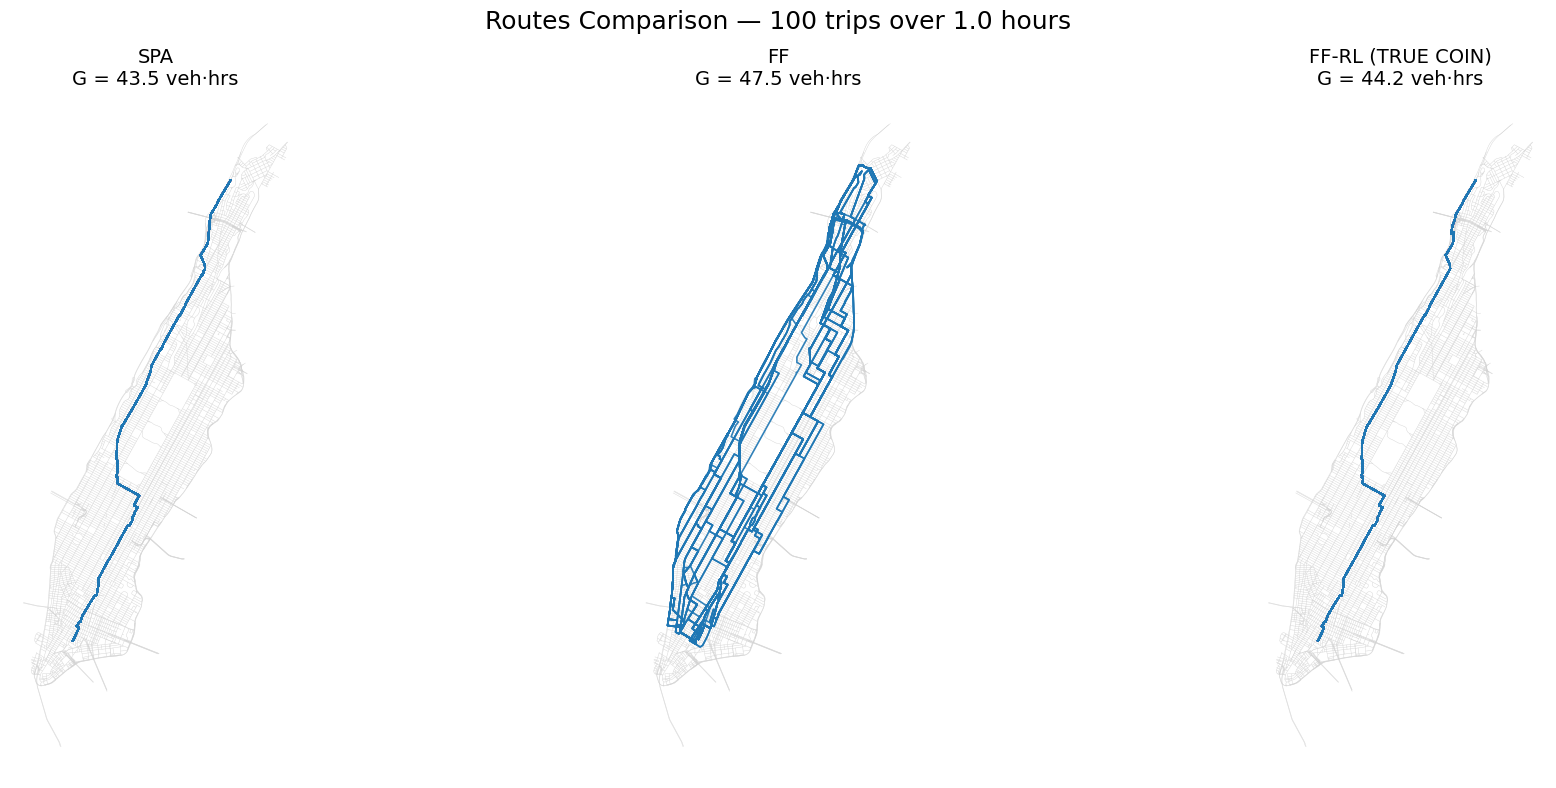

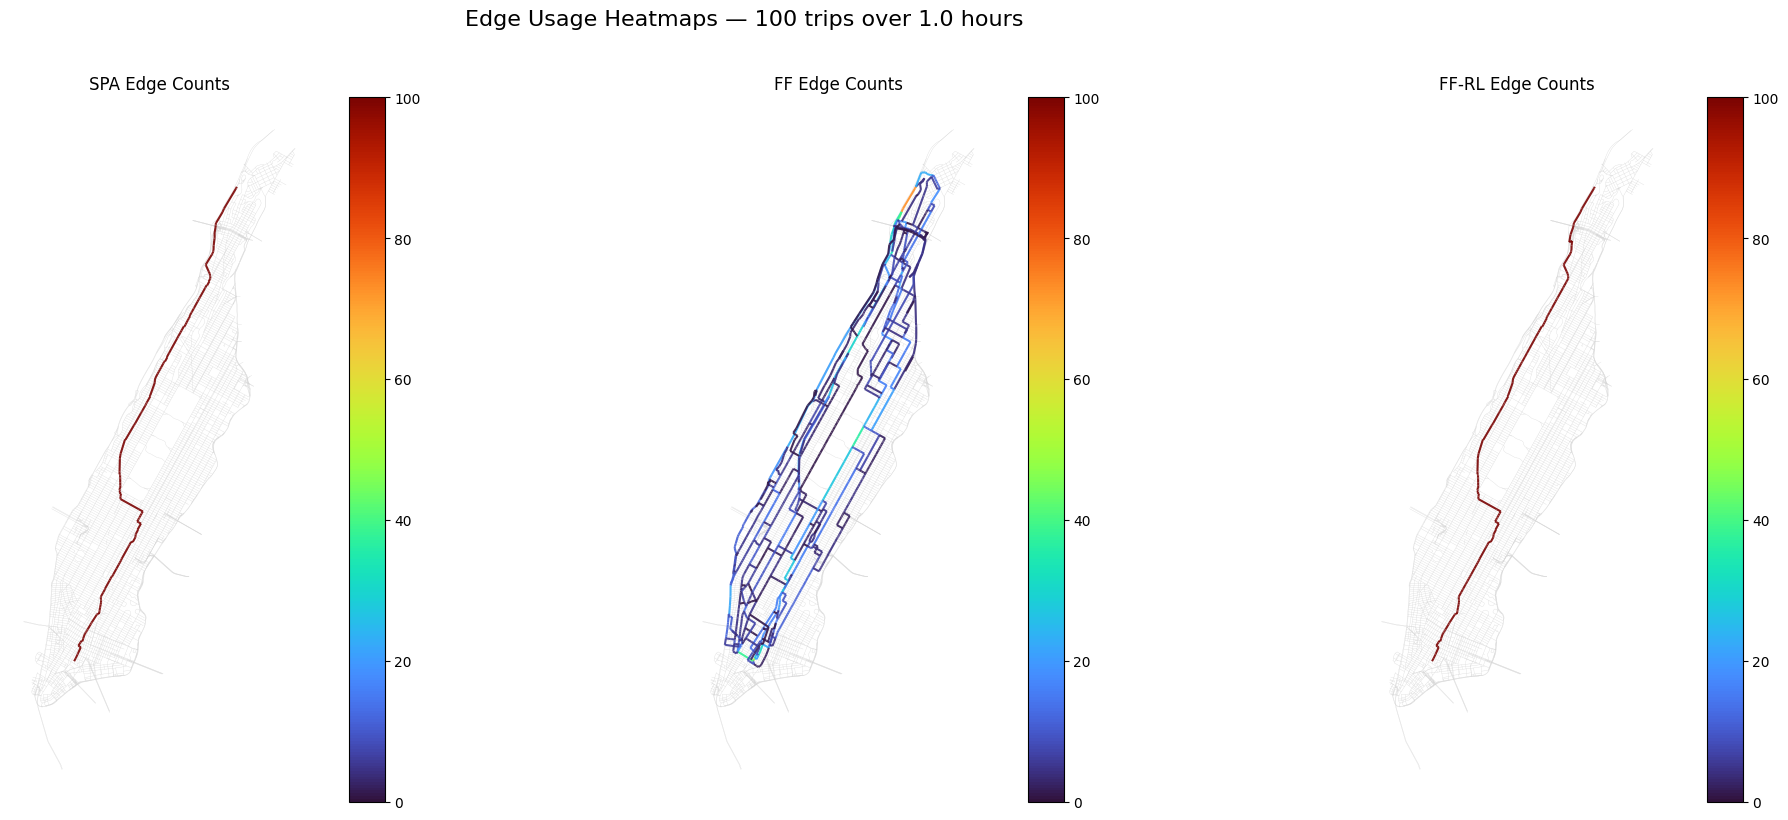

In [641]:
plot_routes_three_way(
    gdf,
    agents_spa, G_spa,
    agents_ff, G_ff,
    agents_ff_rl, G_ff_rl,
    num_agents=num_agents,
    horizon_s=horizon_s,
)

plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_ff,
    flows_ff_rl,
    num_agents=num_agents,
    horizon_s=horizon_s,
)

X# Grid Search for Hyperparameters

In [486]:
import itertools
import time
import pandas as pd

def grid_search_coin(
    network,
    param_grid: dict,
    *,
    # fixed experiment settings
    seed: int = 26,
    num_agents: int = 1000,
    num_agents_expert: int | None = None,
    horizon_s: float = 3600.0,
    od_mode: str = "north_south",
    steps_per_agent: int = 1500,
    # constraint
    min_reach: float = 0.90,
    # runtime / logging
    debug: bool = False,
    verbose_every: int = 1,
):
    """
    Grid search over run_ff_expert_coin_rl_experiment hyperparameters.

    Selection rule:
      - Only keep configs with reach_ff_rl >= min_reach
      - Among them, minimize G_ff_rl (veh-hours in your print)

    Returns:
      results_df (all trials)
      best_row (pd.Series or None if no feasible config)
    """
    if num_agents_expert is None:
        num_agents_expert = num_agents // 3

    # build all combinations
    keys = list(param_grid.keys())
    values_lists = [param_grid[k] for k in keys]
    combos = list(itertools.product(*values_lists))

    rows = []
    feasible_rows = []

    for i, vals in enumerate(combos, start=1):
        params = dict(zip(keys, vals))

        # make runs reproducible *per combo*
        random.seed(seed)
        t0 = time.time()

        try:
            (
                agents_spa,  flows_spa,  G_spa,
                agents_ff,   flows_ff,   G_ff,
                agents_ff_rl, flows_ff_rl, G_ff_rl,
                Q_ff_rl,
            ) = run_ff_expert_coin_rl_experiment(
                network,

                # --- fixed populations ---
                num_agents_baseline=num_agents,
                num_agents_expert=num_agents_expert,
                num_agents_eval_rl=num_agents,
                od_mode=od_mode,

                # --- fixed horizon + steps ---
                steps_per_agent=steps_per_agent,
                horizon_s=horizon_s,

                # --- tuned hyperparams from grid ---
                **params,

                # --- reduce spam unless debugging ---
                debug=debug,
            )

            reach_spa = fraction_reached_agentspecific(agents_spa)
            reach_ff  = fraction_reached_agentspecific(agents_ff)
            reach_rl  = fraction_reached_agentspecific(agents_ff_rl)

            elapsed = time.time() - t0

            row = {
                "trial": i,
                "elapsed_s": elapsed,

                "reach_spa": reach_spa,
                "reach_ff": reach_ff,
                "reach_ff_rl": reach_rl,

                "G_spa_vehhrs": G_spa / 3600.0,
                "G_ff_vehhrs": G_ff / 3600.0,
                "G_ff_rl_vehhrs": G_ff_rl / 3600.0,

                "feasible": (reach_rl >= min_reach),
            }
            row.update(params)

            rows.append(row)
            if row["feasible"]:
                feasible_rows.append(row)

            if verbose_every and (i % verbose_every == 0):
                print(
                    f"[{i}/{len(combos)}] reach_rl={reach_rl:.3f} "
                    f"G_rl={row['G_ff_rl_vehhrs']:.1f} veh·hrs "
                    f"feasible={row['feasible']} params={params}"
                )

        except Exception as e:
            elapsed = time.time() - t0
            row = {
                "trial": i,
                "elapsed_s": elapsed,
                "error": repr(e),
                "feasible": False,
            }
            row.update(params)
            rows.append(row)

            print(f"[{i}/{len(combos)}] ERROR: {e} params={params}")

    results_df = pd.DataFrame(rows)

    best_row = None
    if feasible_rows:
        feasible_df = pd.DataFrame(feasible_rows)
        best_idx = feasible_df["G_ff_rl_vehhrs"].idxmin()
        best_row = feasible_df.loc[best_idx]

    return results_df, best_row

## Parameter Grid

In [411]:
param_grid = {
    # ==========================================================
    # ✅ VARIED (minimal, high-impact)
    # ==========================================================
    "temperature": [0.1, 0.3, 0.6],
    "lambda_live_cost": [0.5, 1.0, 2.0,2.5],
    "visited_penalty_val": [1.0, 3.0, 6.0, 10.0],
    "epsilon_eval": [0.01],

    # ==========================================================
    # 🔒 FIXED (keep constant while you tune policy behavior)
    # ==========================================================
    # training schedule
    "epsilon_start": [0.4],
    "epsilon_end": [0.1],
    "num_episodes_rl": [40],
    "visited_penalty_train": [1.0],

    # reward weights
    "lambda_dr": [0.2],
    "lambda_prog": [1.0],
    "lambda_exp": [0.1],
    "lambda_step": [0.1],

    # scaling
    "time_scale": [5000],

    # terminal shaping
    "lambda_term": [600.0],
    "lambda_miss": [300.0],
}

## Grid Run

In [389]:
results_df, best = grid_search_coin(
    manhattan_network,
    param_grid,
    seed=26,
    num_agents=1000,
    horizon_s=3600.0,
    od_mode="north_south",
    steps_per_agent=1500,
    min_reach=0.10,
    debug=False,
    verbose_every=1,
)

print("\n=== Grid search done ===")
print("Total trials:", len(results_df))
print("Feasible trials:", int(results_df["feasible"].sum()) if "feasible" in results_df else 0)

if best is None:
    print("No feasible config found (reach_ff_rl >= 0.90).")
else:
    print("\n=== Best feasible config (min G_ff_rl) ===")
    display(best)  # in notebook

SPA experiment with 1000 agents (north_south O/D)
Used edges: 4948 / 16444
FFA experiment with 1000 agents (north_south O/D)
Used edges: 7366 / 16444
Collected 32209 FF-expert (s,d,a,edge_id) steps from 333 agents.
[FF expert] 4840 distinct expert edges.
Initializing TRUE-COIN Q from Ford–Fulkerson expert trajectories...
TRUE-COIN Q initialized on 32209 FF expert steps (unique state–action pairs: 31950).
[TRUE-COIN+Expert] Episode 1/40: epsilon=0.400, avg_return=409.277, avg_steps=839.3
[TRUE-COIN+Expert] Episode 2/40: epsilon=0.392, avg_return=403.066, avg_steps=816.5
[TRUE-COIN+Expert] Episode 3/40: epsilon=0.385, avg_return=363.189, avg_steps=861.8
[TRUE-COIN+Expert] Episode 4/40: epsilon=0.377, avg_return=417.997, avg_steps=771.4
[TRUE-COIN+Expert] Episode 5/40: epsilon=0.369, avg_return=388.604, avg_steps=818.5
[TRUE-COIN+Expert] Episode 6/40: epsilon=0.362, avg_return=402.446, avg_steps=774.6
[TRUE-COIN+Expert] Episode 7/40: epsilon=0.354, avg_return=406.527, avg_steps=789.3
[TRU

trial                           14
elapsed_s                80.288723
reach_spa                    0.912
reach_ff                     0.908
reach_ff_rl                   0.23
G_spa_vehhrs            232.245023
G_ff_vehhrs              297.46848
G_ff_rl_vehhrs         4073.802056
feasible                      True
temperature                    0.1
lambda_live_cost               2.5
visited_penalty_val            3.0
epsilon_eval                  0.01
epsilon_start                  0.4
epsilon_end                    0.1
num_episodes_rl                 40
lambda_dr                      0.2
lambda_prog                    1.0
lambda_exp                     0.1
lambda_step                    0.1
time_scale                    5000
lambda_term                  600.0
lambda_miss                  300.0
Name: 13, dtype: object

## Best setup run

In [390]:
# =========================
# RUN TRUE COIN + EXPERT EXPERIMENT (BEST GRIDSEARCH CONFIG)
# =========================

if best is None:
    raise ValueError("No feasible config found in grid search (best is None).")

random.seed(26)
num_agents = 1000
num_agents_expert = num_agents // 3
horizon_s = 3600.0
od_mode = "north_south"

# Extract only the hyperparams that belong in the experiment call
BEST_PARAMS = best.to_dict()

# (Optional) drop non-hyperparam columns if they exist in `best`
for k in [
    "trial", "elapsed_s", "reach_spa", "reach_ff", "reach_ff_rl",
    "G_spa_vehhrs", "G_ff_vehhrs", "G_ff_rl_vehhrs", "feasible", "error"
]:
    BEST_PARAMS.pop(k, None)

(
    agents_spa,  flows_spa,  G_spa,
    agents_ff,   flows_ff,   G_ff,
    agents_ff_rl, flows_ff_rl, G_ff_rl,
    Q_ff_rl,
) = run_ff_expert_coin_rl_experiment(
    manhattan_network,

    # fixed experiment settings
    num_agents_baseline=num_agents,
    num_agents_expert=num_agents_expert,
    num_agents_eval_rl=num_agents,
    od_mode=od_mode,
    steps_per_agent=1500,
    horizon_s=horizon_s,

    # best hyperparameters from grid search
    **BEST_PARAMS,

    # your preference
    debug=True,
)

# --- package results neatly ---
spa_results   = (agents_spa,    flows_spa,    G_spa)
ff_results    = (agents_ff,     flows_ff,     G_ff)
ff_rl_results = (agents_ff_rl,  flows_ff_rl,  G_ff_rl)

results = {
    "SPA":                 spa_results,
    "FF":                  ff_results,
    "FF-RL (TRUE COIN + expert)": ff_rl_results,
}

SPA experiment with 1000 agents (north_south O/D)
Used edges: 4948 / 16444
FFA experiment with 1000 agents (north_south O/D)
Used edges: 7366 / 16444
Collected 32209 FF-expert (s,d,a,edge_id) steps from 333 agents.
[FF expert] 4840 distinct expert edges.
Initializing TRUE-COIN Q from Ford–Fulkerson expert trajectories...
TRUE-COIN Q initialized on 32209 FF expert steps (unique state–action pairs: 31950).
[TRUE-COIN+Expert] Episode 1/40: epsilon=0.400, avg_return=409.277, avg_steps=839.3

[Episode 1 reward breakdown] n=279499
  delta_G   mean= 11.5325   min= 0.1183   max= 390.4225
  dr        mean=-0.0005   min=-0.0156   max=-0.0000
  exp       mean= 0.0406   min= 0.0000   max= 0.1000
  miss      mean=-0.0547   min=-300.0000   max= 0.0000
  prog      mean=-0.0032   min=-1.0000   max= 1.0000
  step      mean=-0.1000   min=-0.1000   max=-0.1000
  term      mean= 0.6054   min= 0.0000   max= 600.0000
  total     mean= 0.4876   min=-301.1007   max= 601.0000
[ΔG percentiles] p50=5.970 p90=24.

## Best setup results

In [391]:
print(f"\n=== Summary for {num_agents} agents ===")

print("========== Fraction reached ==========")
for name, (agents, flows, G) in results.items():
    print(f"[{name}] - reaching dest: {fraction_reached_agentspecific(agents):.3f}")

print("\n========== Scenario metrics ==========")
for name, (agents, flows, G) in results.items():
    n = len(agents)
    print_scenario_metrics(name, manhattan_network, flows, G, n)

# Optional: quick global comparison
print("\n=== Global G comparison (hours) ===")
print(f"G_SPA              = {G_spa/3600:.2f} hrs")
print(f"G_FF               = {G_ff/3600:.2f} hrs")
print(f"G_FF-RL (COIN+exp) = {G_ff_rl/3600:.2f} hrs")
print(f"Improvement (FF-RL vs SPA)     = {(G_spa - G_ff_rl) / G_spa * 100:.2f}%")


=== Summary for 1000 agents ===
========== Fraction reached ==========
[SPA] - reaching dest: 0.912
[FF] - reaching dest: 0.908
[FF-RL (TRUE COIN + expert)] - reaching dest: 0.230

========== Scenario metrics ==========

[SPA] metrics:
  Average travel time per agent:   836.08 s  ( 13.93 min)
  Total distance traveled:       10318.23 km
  Average distance per agent:       10.32 km

[FF] metrics:
  Average travel time per agent:  1070.89 s  ( 17.85 min)
  Total distance traveled:       11482.40 km
  Average distance per agent:       11.48 km

[FF-RL (TRUE COIN + expert)] metrics:
  Average travel time per agent: 14665.69 s  (244.43 min)
  Total distance traveled:       155973.56 km
  Average distance per agent:      155.97 km

=== Global G comparison (hours) ===
G_SPA              = 232.25 hrs
G_FF               = 297.47 hrs
G_FF-RL (COIN+exp) = 4073.80 hrs
Improvement (FF-RL vs SPA)     = -1654.10%


### Best setup parameters

In [500]:
pd.DataFrame(best)

,13
trial,14
elapsed_s,80.288723
reach_spa,0.912
reach_ff,0.908
reach_ff_rl,0.23
G_spa_vehhrs,232.245023
G_ff_vehhrs,297.46848
G_ff_rl_vehhrs,4073.802056
feasible,True
temperature,0.1


## Best setup visualizations

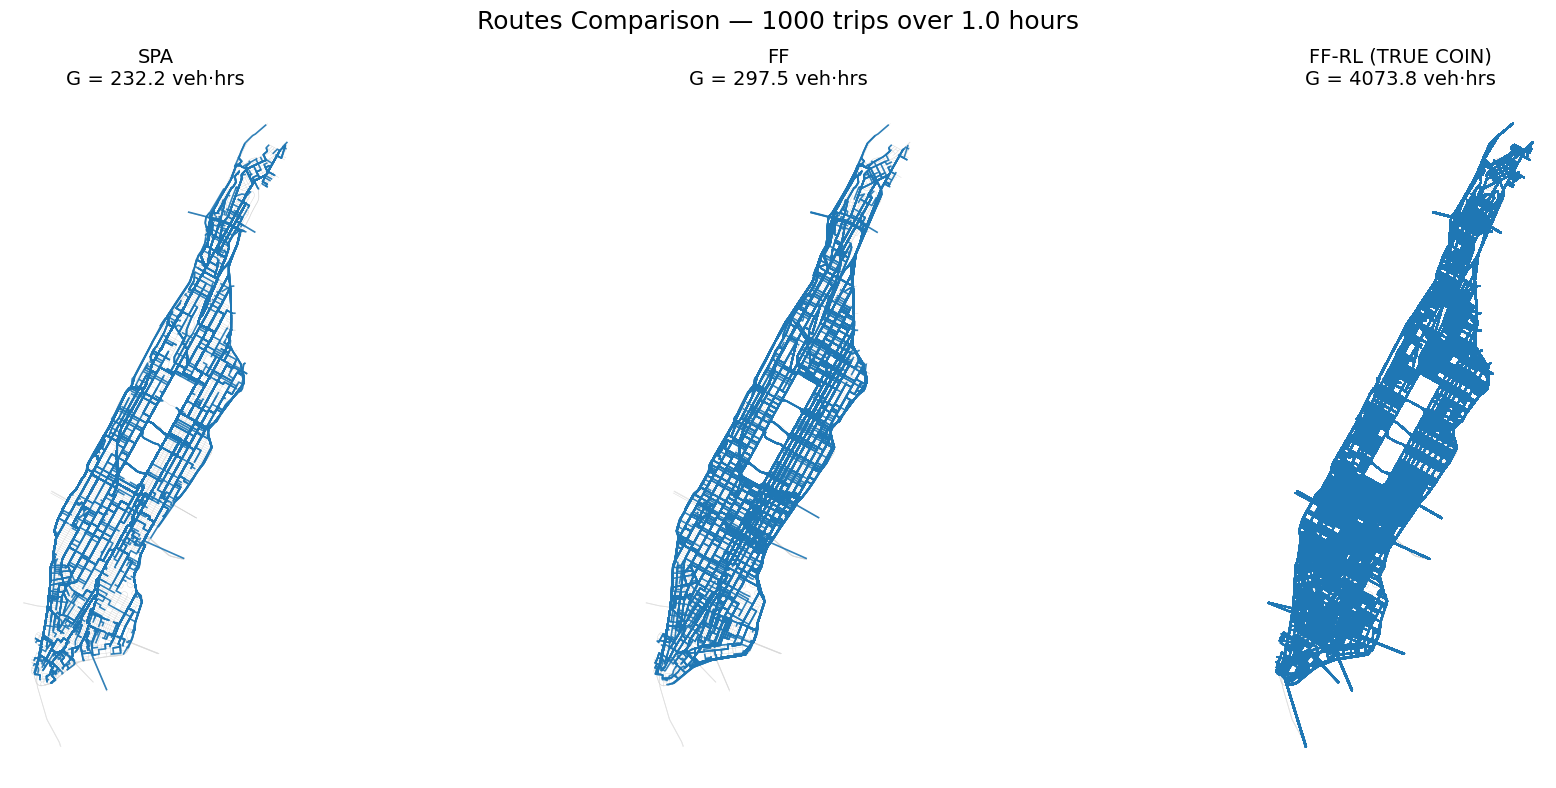

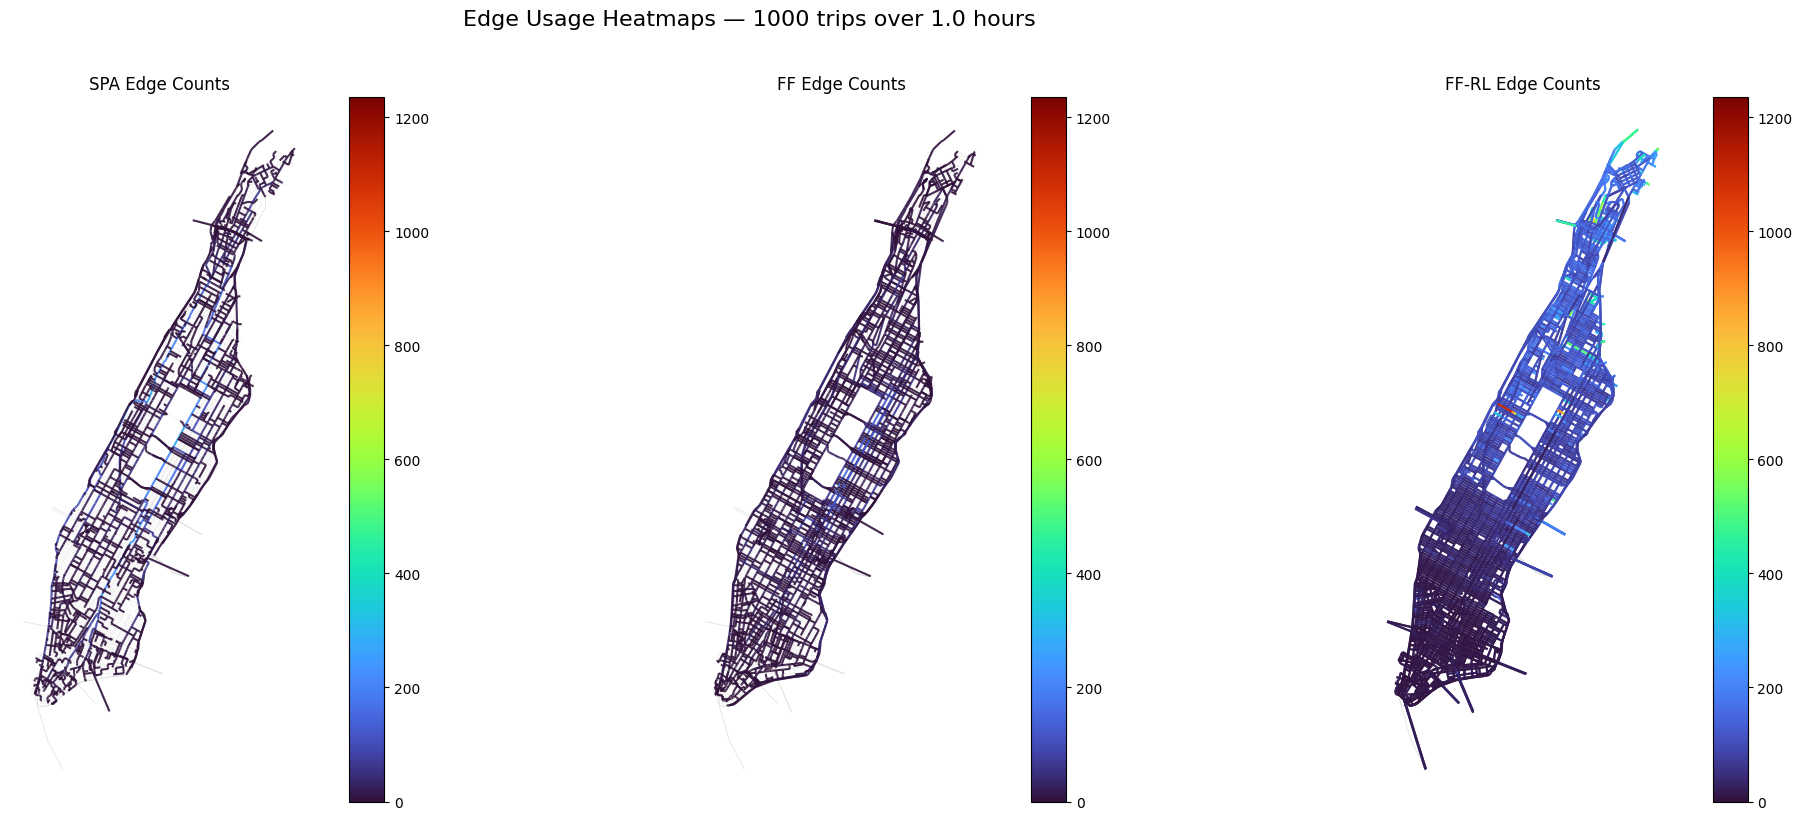

In [394]:
plot_routes_three_way(
    gdf,
    agents_spa, G_spa,
    agents_ff, G_ff,
    agents_ff_rl, G_ff_rl,
    num_agents=num_agents,
    horizon_s=horizon_s,
)

plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_ff,
    flows_ff_rl,
    num_agents=num_agents,
    horizon_s=horizon_s,
)

# Animation

## Animation Helper

In [501]:
def animate_routes_three_way_light(
    gdf: gpd.GeoDataFrame,
    agents_spa: list,
    agents_ff: list,
    agents_ff_rl: list,
    num_agents: int,
    out_path: str | None = None,
    max_frames: int = 80,      # total frames of the animation
    fps: int = 8,              # frames per second
    figsize=(10, 6),           # overall figure size
    dpi: int = 80,             # resolution
):
    """
    Lightweight 3-panel animation of SPA, FF/COIN_FF, and FF-RL (expert COIN) routes.

    Each panel:
      - draws the Manhattan network once as a gray background
      - shows the routes being constructed over time

    The function:
      - sub-samples each path so we only use `max_frames` frames
      - saves as an MP4 (much smaller than GIF)

    Parameters
    ----------
    gdf : GeoDataFrame
        Street network (same you used for static plots).
    agents_spa, agents_ff, agents_ff_rl : list[Agent]
        Agents with .path = [node0, node1, ...].
    num_agents : int
        Number of agents used in the experiment (for title + filename).
    out_path : str or None
        Output file name (MP4). If None, a name with num_agents is used.
    max_frames : int
        Maximum number of frames in the animation.
    fps : int
        Frames per second.
    figsize : tuple
        Matplotlib figure size.
    dpi : int
        Resolution of the saved video.
    """

    # auto-generate filename if not provided
    if out_path is None:
        out_path = f"routes_three_way_{num_agents}_agents.mp4"

    # --- helper: convert Node -> (x, y) ---
    def node_xy(node):
        x, y = node  # your Node is an (x, y) tuple
        return x, y

    # --- prepare figure with 3 subplots ---
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    titles = [
        "SPA routes",
        "FF / COIN_FF routes",
        "FF-RL (Expert COIN) routes",
    ]

    # draw background network once in each subplot
    for ax, title in zip(axes, titles):
        gdf.plot(ax=ax, color="lightgrey", linewidth=0.3)
        ax.set_axis_off()
        ax.set_title(title, fontsize=10)

    # global title with number of agents
    fig.suptitle(
        f"Animation for {num_agents} agents",
        fontsize=12,
        fontweight="bold",
        y=0.97
    )

    # for each scenario, convert paths to (xs, ys) lists
    scenarios_agents = [agents_spa, agents_ff, agents_ff_rl]
    scenarios_paths_xy = []     # per scenario: list of (xs, ys)
    global_max_len = 0          # longest path across all scenarios

    for agents in scenarios_agents:
        paths_xy = []
        for a in agents:
            if not getattr(a, "path", None) or len(a.path) < 2:
                continue
            xs, ys = zip(*[node_xy(n) for n in a.path])
            paths_xy.append((xs, ys))
            global_max_len = max(global_max_len, len(xs))
        scenarios_paths_xy.append(paths_xy)

    if global_max_len == 0:
        print("No non-empty paths to animate.")
        plt.close(fig)
        return

    # total frames = min(max_frames, longest path length)
    n_frames = min(max_frames, global_max_len)

    # for each scenario and each path, precompute indices per frame
    scenarios_indices_per_frame = []
    for paths_xy in scenarios_paths_xy:
        idx_lists = []
        for xs, ys in paths_xy:
            L = len(xs)
            if L <= 1:
                idx_lists.append([0] * n_frames)
                continue
            idxs = [
                min(int((k / (n_frames - 1)) * (L - 1)), L - 1)
                for k in range(n_frames)
            ]
            idx_lists.append(idxs)
        scenarios_indices_per_frame.append(idx_lists)

    # line objects for each path in each scenario
    scenarios_lines = []
    for ax, paths_xy in zip(axes, scenarios_paths_xy):
        scenario_lines = []
        for xs, ys in paths_xy:
            line, = ax.plot([], [], linewidth=1.5)
            scenario_lines.append(line)
        scenarios_lines.append(scenario_lines)

    # --- animation callbacks ---
    def init():
        for scenario_lines in scenarios_lines:
            for line in scenario_lines:
                line.set_data([], [])
        return [line for scenario_lines in scenarios_lines for line in scenario_lines]

    def update(frame):
        for paths_xy, idx_lists, lines in zip(
            scenarios_paths_xy,
            scenarios_indices_per_frame,
            scenarios_lines
        ):
            for (xs, ys), idxs, line in zip(paths_xy, idx_lists, lines):
                idx = idxs[frame]
                line.set_data(xs[:idx + 1], ys[:idx + 1])

        return [line for scenario_lines in scenarios_lines for line in scenario_lines]

    anim = FuncAnimation(
        fig,
        update,
        frames=n_frames,
        init_func=init,
        blit=True,
        interval=1000 // fps,
    )

    # save as MP4 (small-ish)
    writer = FFMpegWriter(fps=fps, bitrate=1200)  # tweak bitrate if you want smaller file
    anim.save(out_path, writer=writer, dpi=dpi)
    plt.close(fig)

    print(
        f"Saved 3-way route animation to {out_path} "
        f"({n_frames} frames, {fps} fps, {num_agents} agents)"
    )

## Run animation

In [ ]:
animate_routes_three_way_light(
    gdf,
    agents_spa,
    agents_ff,
    agents_ff_rl,
    num_agents=num_agents,
    out_path=None,        # or leave out to auto-name with num_agents
    max_frames=80,
    fps=8,
)